# Visitor Prediction in the Library of buisness administration (BWI)

**Lecture:** Selected Topics in AI<br>
**Lecturer:** Prof. Dr. Johannes Maucher

**Group:**
- Firaz Ilhan
- Patryk Gadziomski

<div style="width: 100%; height: 30px; background-color:red"></div>

## 0. Import Requirements

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from meteostat import Point, Daily
import datetime
import torch
import torch.nn as nn
from copy import deepcopy as dc
import holidays
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

Für das Ausführen des Models, sowie das Training wird die GPU benutzt. Falls diese nicht vorhanden sein sollte, wird stattdessen die CPU benutzt.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Data Exploration

In diesem Schritt werden die Daten geladen und näher betrachtet.
Bei den Daten handelt es sich um selbst erfasste Daten aus der BWI-Bibliothek der Universität Stuttgart. Diese stellen die Besucheranzahl der Bibliothek dar.

Auf den erstenB Blick wird klar, das die Daten sehr viele fehlende Werte aufweisen.
Diese müssen im weiteren Vorgehen gefüllt werden.

In [3]:
# Read excel file as dataframe: visitor_data
visitor_data = pd.read_excel("data/new_data.xlsx")
visitor_data.head()

,timestemp,value
0,2022-03-28 09:30:00,NaN
1,2022-03-28 10:45:00,NaN
2,2022-03-28 13:45:00,NaN
3,2022-03-28 16:15:00,NaN
4,2022-03-28 17:45:00,NaN


In [4]:
visitor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestemp  4896 non-null   datetime64[ns]
 1   value      3782 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.6 KB


In [5]:
visitor_data.describe()

,value
count,3782.000000
mean,2.870968
std,3.526116
min,0.000000
25%,0.000000
50%,2.000000
75%,5.000000
max,20.000000


<Axes: xlabel='timestemp'>

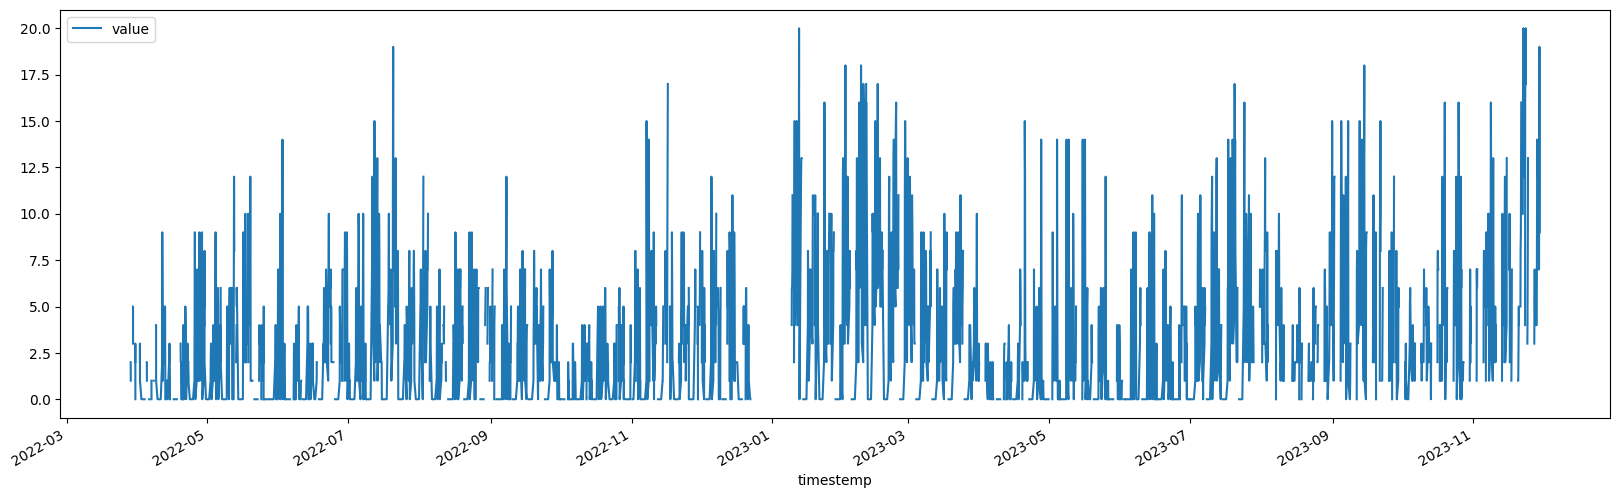

In [6]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 2. Data Preprocessing

Im Preprocessing Schritt geht es darum die fehlende Werte zu ergänzen.
Für das Auffüllen der fehlenden Werte wird die `bachfill`-Methode eingesetzt, welche die fehlenden Werte anhand der vergangenen Werte auffüllt.

In [7]:
# Missing Values Handling
visitor_data['value'] = visitor_data['value'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)

<Axes: xlabel='timestemp'>

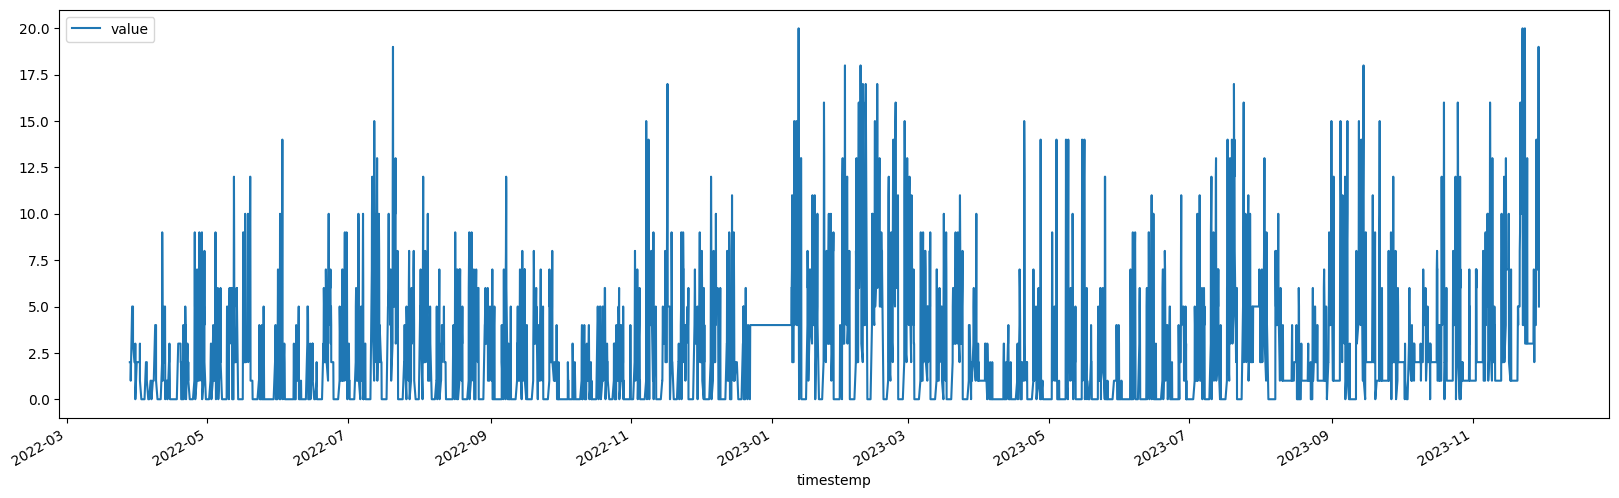

In [8]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 3. Feature Extraction

Anhand der vorhandenen feautures: "timestemp" werden weitere features extrahiert:

- Datum
- Wochentag
- Wochenende
- Prüfungsphase
- Ferien/Feiertage
- Wetterdaten

Außerdem werden für den Input des LSTM-Models die Sequenzen erstellt, welche die werte der letzten zwei Wochen beinhalten.

In [9]:
# das Datum extrahieren
date_list = []

for i in visitor_data["timestemp"]:
    new_date = (str(i)[0:10])
    new_date = datetime.datetime.strptime(new_date,'%Y-%m-%d')
    date_list.append(new_date)

visitor_data["date"] = date_list

In [10]:
# add column "weekday"
visitor_data["weekday"] = [weekday for weekday in visitor_data["timestemp"].dt.dayofweek]

In [11]:
# Check if weekday or weekend
weekend_list = []

for timestemp in visitor_data['weekday']:
    if timestemp == 5 or timestemp == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

visitor_data['weekend'] = weekend_list

In [12]:
# Set all values, where weekend day is 1 to 0
visitor_data.loc[visitor_data['weekend'].eq(1), 'value'] = 0

In [13]:
# Vorlesungspahse = 0, Pfürungsphase = 1
exam_phase_ws_2021_begin = datetime.datetime(2022, 2, 10)
exam_phase_ws_2021_end = datetime.datetime(2022, 3, 31)

exam_phase_ss_2022_begin = datetime.datetime(2022, 7, 20)
exam_phase_ss_2022_end = datetime.datetime(2022, 9, 30)

exam_phase_ws_2022_begin = datetime.datetime(2023, 2, 10)
exam_phase_ws_2022_end = datetime.datetime(2023, 3, 31)

exam_phase_ss_2023_begin = datetime.datetime(2023, 7, 20)
exam_phase_ss_2023_end = datetime.datetime(2023, 9, 30)

exam_phase_ws_2023_begin = datetime.datetime(2024, 2, 10)
exam_phase_ws_2023_end = datetime.datetime(2024, 3, 31)

In [14]:
# Exam Phase
exam_phase_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= exam_phase_ws_2021_begin and timestemp <= exam_phase_ws_2021_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2022_begin and timestemp <= exam_phase_ss_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2022_begin and timestemp <= exam_phase_ws_2022_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ss_2023_begin and timestemp <= exam_phase_ss_2023_end:
        exam_phase_list.append(1)
    elif timestemp >= exam_phase_ws_2023_begin and timestemp <= exam_phase_ws_2023_end:
        exam_phase_list.append(1)
    else:
        exam_phase_list.append(0)

exam_phase_list

visitor_data['exam_phase'] = exam_phase_list

In [15]:
# Check if holiday, or not; holiday = 1, else = 0

de_holidays = holidays.country_holidays('DE', subdiv='BW')

holiday_array = []

for date in visitor_data['date']:
    if date in de_holidays:
        holiday_array.append(1)
    else:
        holiday_array.append(0)

visitor_data['holiday'] = holiday_array

visitor_data.loc[visitor_data['holiday'].eq(1), 'value'] = 0

In [16]:
# Set the values of the winter vacations to 0, and holiday to 1

wv_begin_2022 = datetime.datetime(2022, 12, 23)
wv_end_2022 = datetime.datetime(2023, 1, 8)

wv_begin_2023 = datetime.datetime(2023, 12, 23)
wv_end_2023 = datetime.datetime(2024, 1, 7)

wv_list = []

for timestemp in visitor_data['timestemp']:
    if timestemp >= wv_begin_2022 and timestemp <= wv_end_2022:
        wv_list.append(1)
    elif timestemp >= wv_begin_2023 and timestemp <= wv_end_2023:
        wv_list.append(1)
    else:
        wv_list.append(0)

visitor_data['winter_vacation'] = wv_list

visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'value'] = 0
visitor_data.loc[visitor_data['winter_vacation'].eq(1), 'holiday'] = 1

In [17]:
# Die Vergangeheitswerte t-1 etc. bekommen
def prepare_dateframe_for_lstm(df, n_steps):
    # use a copy instead of the original data frame object 
    df = df.copy()

    cols = [df['value']
            .shift(i)
            .rename(f'value (t-{i})') 
            for i in range(1, n_steps + 1)]
    
    df = pd.concat([df] + cols, axis=1)
    
    df.dropna(inplace=True)
    
    return df

lookback = 112 # Hier rumspielen
visitor_data = prepare_dateframe_for_lstm(visitor_data, lookback)

# wenn wir zwei Wochen übergeben wollen, müssen wir 8*14=112 Werte zurück gehen...

In [18]:
# Get the weather data until today
today_year = int(str(datetime.datetime.today())[0:4])
today_month = int(str(datetime.datetime.today())[5:7])
today_day = int(str(datetime.datetime.today())[8:10])

# get weather data thorught the date
start = datetime.datetime(2022, 3, 28)
end = datetime.datetime(today_year, today_month, today_day)

# Stuttgart
location = Point(48.7823200, 9.1770200, 252)

weather_data = Daily(location, start, end)
weather_data = weather_data.fetch()

"""
time: The date string (format: YYYY-MM-DD)      : String
tavg: The average air temperature in °C         : Float
tmin: The minimum air temperature in °C         : Float
tmax: The maximum air temperature in °C	        : Float
prcp: The daily precipitation total in mm       : Float
snow: The maximum snow depth in mm	            : Integer
wdir: The average wind direction in degrees (°)	: Integer
wspd: The average wind speed in km/h	        : Float
wpgt: The peak wind gust in km/h	            : Float
pres: The average sea-level air pressure in hPa	: Float
tsun: The daily sunshine total in minutes (m)	: Integer
"""
weather_data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-03-28,13.2,4.9,20.7,0.0,0.0,160.0,10.8,30.6,1021.4,630.0
2022-03-29,12.6,7.0,17.4,1.8,0.0,133.0,8.6,22.7,1009.8,210.0
2022-03-30,9.0,6.9,11.2,0.8,0.0,300.0,7.2,30.6,1001.8,0.0
2022-03-31,6.4,4.5,9.0,14.9,0.0,2.0,9.7,31.7,996.7,3.0
2022-04-01,1.9,-0.2,4.5,8.7,0.0,337.0,12.2,28.1,1001.3,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-01-05,7.1,4.9,9.0,0.0,0.0,185.0,8.6,35.3,1004.8,0.0
2024-01-06,5.0,4.5,5.5,0.0,0.0,292.0,8.9,25.0,1009.1,NaN
2024-01-07,2.4,-1.6,4.7,0.0,NaN,357.0,11.3,25.9,1016.7,NaN


In [19]:
# weather_data.plot(y=['tavg', 'tmin', 'tmax'], figsize=(20, 4))
# plt.show()

<Axes: xlabel='timestemp'>

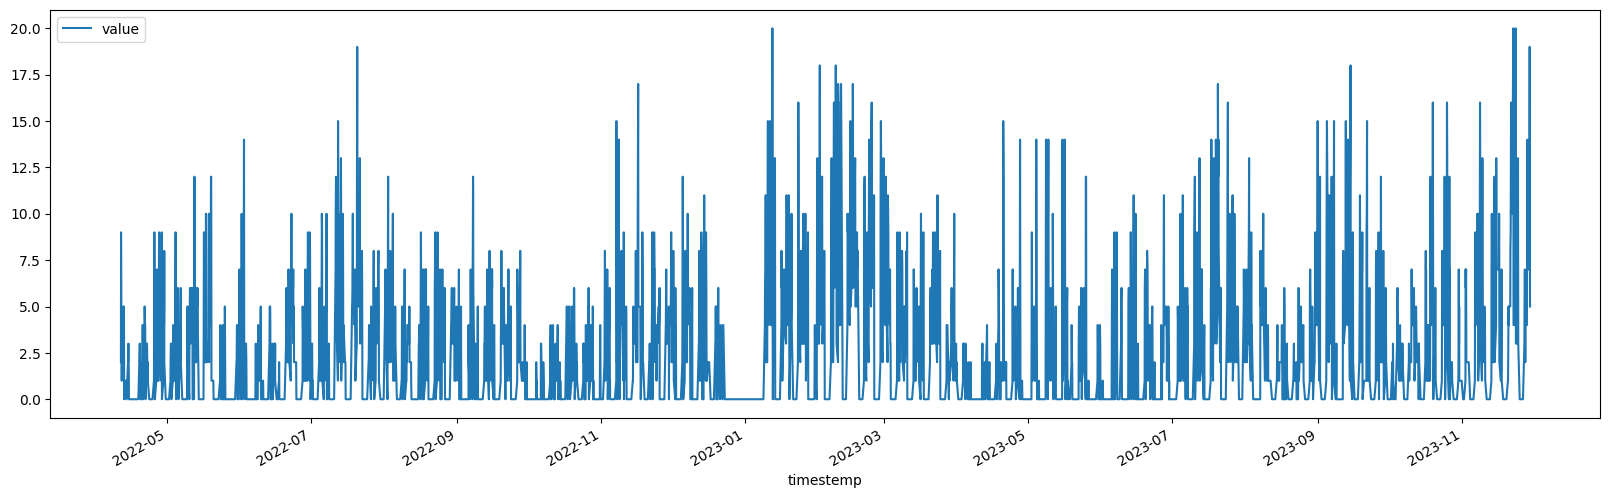

In [20]:
visitor_data.plot(x="timestemp", y="value", figsize=(20, 6))

## 4. JOIN both dataframes (visitor_data + weather_data) and calculate correlations

In [21]:
# merge data frames
visitor_data = visitor_data.merge(
    weather_data,
    left_on="date",
    right_on="time"
)

visitor_data

,timestemp,value,date,weekday,weekend,exam_phase,holiday,winter_vacation,value (t-1),value (t-2),...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2022-04-11 09:30:00,2.0,2022-04-11,0,0,0,0,0,0.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
1,2022-04-11 10:45:00,9.0,2022-04-11,0,0,0,0,0,2.0,0.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
2,2022-04-11 13:45:00,5.0,2022-04-11,0,0,0,0,0,9.0,2.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
3,2022-04-11 16:15:00,5.0,2022-04-11,0,0,0,0,0,5.0,9.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
4,2022-04-11 17:45:00,1.0,2022-04-11,0,0,0,0,0,5.0,5.0,...,9.1,0.9,16.5,0.0,0.0,125.0,9.0,31.0,1017.6,709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,2023-11-29 13:45:00,19.0,2023-11-29,2,0,0,0,0,7.0,7.0,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4779,2023-11-29 16:15:00,19.0,2023-11-29,2,0,0,0,0,19.0,7.0,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4780,2023-11-29 17:45:00,9.0,2023-11-29,2,0,0,0,0,19.0,19.0,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0
4781,2023-11-29 18:00:00,5.0,2023-11-29,2,0,0,0,0,9.0,19.0,...,1.3,-1.1,4.3,0.1,0.0,209.0,9.4,29.5,1007.5,72.0


In [22]:
visitor_data.set_index('timestemp', inplace=True)
# visitor_data

In [23]:
#calculate correlations between all features of your data frame (see Exploration lab)
data_corr = visitor_data.corr()
# data_corr

In [24]:
data_corr_label = visitor_data.iloc[:, :].corr()["value"]
data_corr_label[112:]

value (t-107)    0.176321
value (t-108)    0.166370
value (t-109)    0.195768
value (t-110)    0.294914
value (t-111)    0.425288
value (t-112)    0.511241
tavg            -0.103441
tmin            -0.096834
tmax            -0.092813
prcp             0.012443
snow            -0.022010
wdir            -0.021816
wspd             0.026588
wpgt            -0.013010
pres             0.023036
tsun            -0.066404
Name: value, dtype: float64

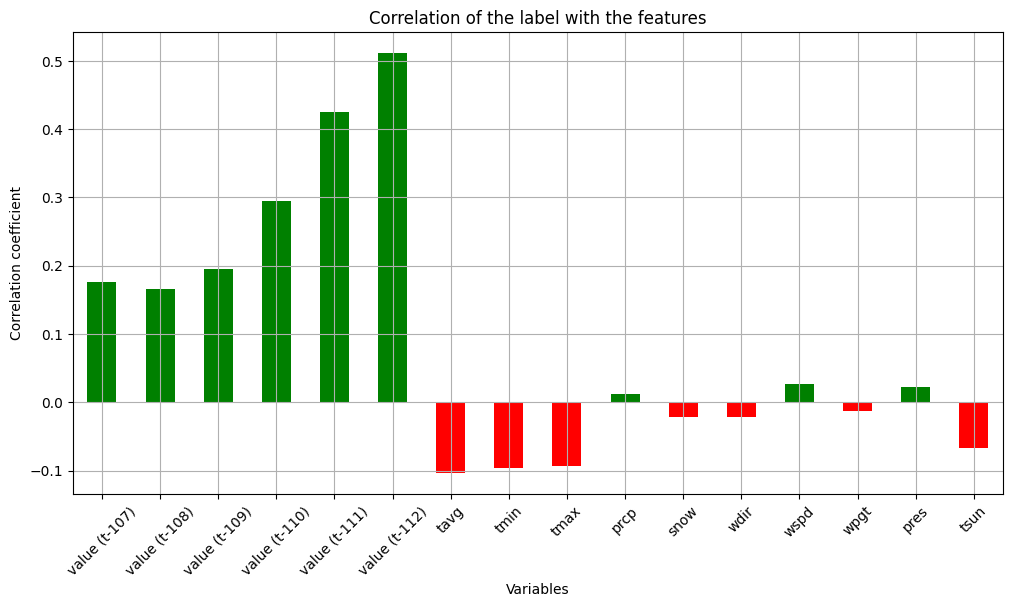

In [25]:
colors = ['green' if x > 0 else 'red' for x in data_corr_label[112:]]

plt.figure(figsize=(12, 6))
data_corr_label[112:].plot(kind='bar', color=colors)
plt.title('Correlation of the label with the features')
plt.xlabel('Variables')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 5. Prepare Data for Model

In [26]:
# drop unnecessary features
droplist = ['date', 'winter_vacation', 'weekend', 'pres', 'wdir', 'snow', 'wspd', 'tmax', 'tmin']
visitor_data = visitor_data.drop(droplist, axis=1)

visitor_data

,value,weekday,exam_phase,holiday,value (t-1),value (t-2),value (t-3),value (t-4),value (t-5),value (t-6),...,value (t-107),value (t-108),value (t-109),value (t-110),value (t-111),value (t-112),tavg,prcp,wpgt,tsun
timestemp,,,,,,,,,,,,,,,,,,,,,
2022-04-11 09:30:00,2.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,9.1,0.0,31.0,709.0
2022-04-11 10:45:00,9.0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2.0,2.0,2.0,2.0,9.1,0.0,31.0,709.0
2022-04-11 13:45:00,5.0,0,0,0,9.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,2.0,2.0,2.0,9.1,0.0,31.0,709.0
2022-04-11 16:15:00,5.0,0,0,0,5.0,9.0,2.0,0.0,0.0,0.0,...,5.0,1.0,1.0,2.0,2.0,2.0,9.1,0.0,31.0,709.0
2022-04-11 17:45:00,1.0,0,0,0,5.0,5.0,9.0,2.0,0.0,0.0,...,5.0,5.0,1.0,1.0,2.0,2.0,9.1,0.0,31.0,709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 13:45:00,19.0,2,0,0,7.0,7.0,7.0,11.0,11.0,12.0,...,7.0,7.0,7.0,7.0,7.0,7.0,1.3,0.1,29.5,72.0
2023-11-29 16:15:00,19.0,2,0,0,19.0,7.0,7.0,7.0,11.0,11.0,...,7.0,7.0,7.0,7.0,7.0,7.0,1.3,0.1,29.5,72.0
2023-11-29 17:45:00,9.0,2,0,0,19.0,19.0,7.0,7.0,7.0,11.0,...,7.0,7.0,7.0,7.0,7.0,7.0,1.3,0.1,29.5,72.0


In [27]:
visitor_data.shape

(4783, 120)

In [28]:
# Convert dataframe to numeric numpy arrays
new_visitor_data = visitor_data.to_numpy()
new_visitor_data

array([[2.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 3.10e+01, 7.09e+02],
       [9.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 3.10e+01, 7.09e+02],
       [5.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 3.10e+01, 7.09e+02],
       ...,
       [9.00e+00, 2.00e+00, 0.00e+00, ..., 1.00e-01, 2.95e+01, 7.20e+01],
       [5.00e+00, 2.00e+00, 0.00e+00, ..., 1.00e-01, 2.95e+01, 7.20e+01],
       [5.00e+00, 2.00e+00, 0.00e+00, ..., 1.00e-01, 2.95e+01, 7.20e+01]])

In [29]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
new_visitor_data = scaler.fit_transform(new_visitor_data)

new_visitor_data

array([[0.1       , 0.        , 0.        , ..., 0.        , 0.28027211,
        0.77233115],
       [0.45      , 0.        , 0.        , ..., 0.        , 0.28027211,
        0.77233115],
       [0.25      , 0.        , 0.        , ..., 0.        , 0.28027211,
        0.77233115],
       ...,
       [0.45      , 0.33333333, 0.        , ..., 0.00265957, 0.25986395,
        0.07843137],
       [0.25      , 0.33333333, 0.        , ..., 0.00265957, 0.25986395,
        0.07843137],
       [0.25      , 0.33333333, 0.        , ..., 0.00265957, 0.25986395,
        0.07843137]])

In [30]:
# Split into features and labels

data_features = new_visitor_data[:, 1:]
data_labels = new_visitor_data[:, 0]

data_features.shape, data_labels.shape

((4783, 119), (4783,))

In [31]:
# Flip the data because of the order of the sequence
data_features = dc(np.flip(data_features, axis=1))
data_features

array([[0.77233115, 0.28027211, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.77233115, 0.28027211, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.77233115, 0.28027211, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07843137, 0.25986395, 0.00265957, ..., 0.        , 0.        ,
        0.33333333],
       [0.07843137, 0.25986395, 0.00265957, ..., 0.        , 0.        ,
        0.33333333],
       [0.07843137, 0.25986395, 0.00265957, ..., 0.        , 0.        ,
        0.33333333]])

In [32]:
# Train test Split
split_index = int(len(data_features) * 0.8)

train_features = data_features[:split_index]
test_features = data_features[split_index:]

train_labels = data_labels[:split_index]
test_labels = data_labels[split_index:]

In [33]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((3826, 119), (3826,), (957, 119), (957,))

In [34]:
# Reshape the arrays into 3-dimeniosnal arrays.
# LSTM-Models requires a 3-dimensional input.
goback = len(visitor_data.columns) -1

train_features = train_features.reshape((-1, goback, 1))
test_features = test_features.reshape((-1, goback, 1))

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

((3826, 119, 1), (957, 119, 1), (3826, 1), (957, 1))

In [35]:
# Turn the data into tensors
train_features = torch.tensor(train_features).float()
train_labels = torch.tensor(train_labels).float()

test_features = torch.tensor(test_features).float()
test_labels = torch.tensor(test_labels).float()

train_features.shape, test_features.shape, train_labels.shape, test_labels.shape

(torch.Size([3826, 119, 1]),
 torch.Size([957, 119, 1]),
 torch.Size([3826, 1]),
 torch.Size([957, 1]))

## 6. Dataset and DataLoader

In [36]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(train_features, train_labels)
test_dataset = TimeSeriesDataset(test_features, test_labels)

In [37]:
train_dataset, test_dataset

(<__main__.TimeSeriesDataset at 0x23e48e9a050>,
 <__main__.TimeSeriesDataset at 0x23e4b292850>)

In [38]:
BS = 4

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

for x, y in train_loader:
    print(f"Input Batch Shape: {x.shape} - (batch size, Features, scalar label)")
    print(f"Label Batch Shape: {y.shape} - (batch size, label dimension)")
    break

Input Batch Shape: torch.Size([4, 119, 1]) - (batch size, Features, scalar label)
Label Batch Shape: torch.Size([4, 1]) - (batch size, label dimension)


## 7. Build Model

### 7.1. LSTM Model Architecture

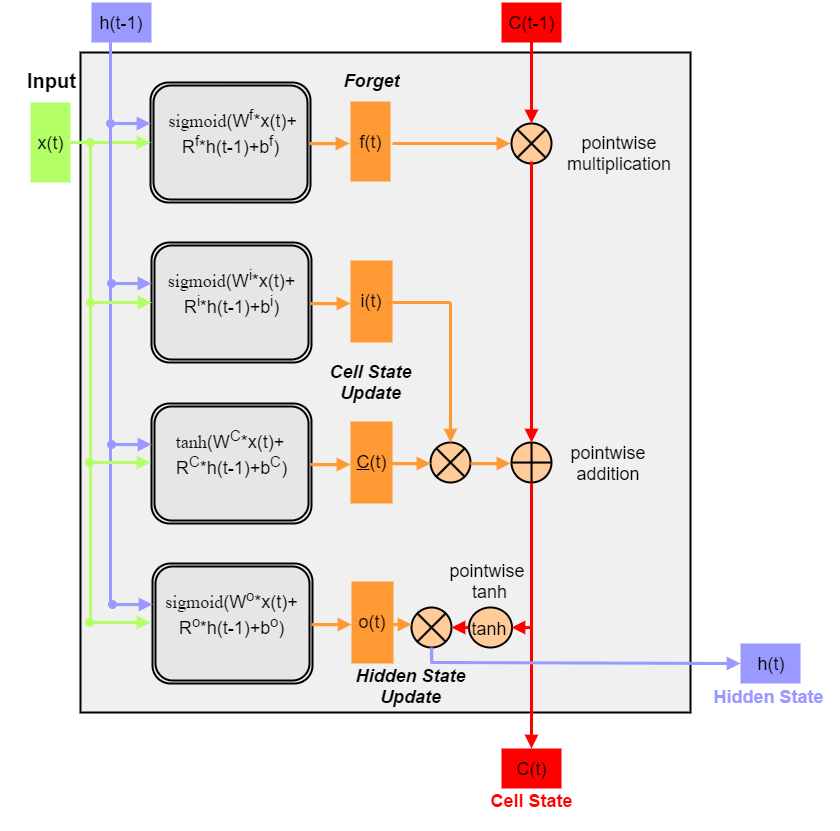

https://griesshaber.pages.mi.hdm-stuttgart.de/nlp/07neuralnetworks/02RecurrentNeuralNetworks.html

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(LSTMModel, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.output_size = output_size
        self.dropout = 0.1

        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_layer_size,
                            num_layers=self.num_layers, 
                            dropout=self.dropout)
        self.linear = nn.Linear(self.hidden_layer_size, self.output_size)
        
        self.hidden_cell = (
            torch.zeros(self.num_layers, 1, self.hidden_layer_size),
            torch.zeros(self.num_layers, 1, self.hidden_layer_size),
        )
    
    def forward(self, input_seq):
        input_seq_reshaped = input_seq.view(len(input_seq), 1, -1)

        lstm_out, self.hidden_cell = self.lstm(input_seq_reshaped, self.hidden_cell)

        lstm_out_reshaped = lstm_out.view(len(input_seq), -1)

        predictions = self.linear(lstm_out_reshaped)

        return predictions


### 7.2. Training

In [40]:
loss_list = []
input_size = goback
hidden_layer_size = 100
output_size = 1
num_layers = 2
learning_rate = 0.001

model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
epochs = 3

print(f"Using: {device} for training")

for epoch in range(epochs):
    model.train()
    
    # reset the hidden state at each loop
    model.hidden_cell = (
        torch.zeros(num_layers, 1, model.hidden_layer_size),
        torch.zeros(num_layers, 1, model.hidden_layer_size),
    )

    for i, (x_batch, y_batch) in enumerate(train_loader):

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # reset the gradients
        optimizer.zero_grad()

        # prevent backpropagating of the dataset
        model.hidden_cell = (
            model.hidden_cell[0].detach(),
            model.hidden_cell[1].detach(),
        )

        # forward pass
        y_pred = model(x_batch.float())

        # compute loss
        loss = loss_function(y_pred, y_batch.float())
        loss_list.append(loss.detach().numpy())

        # backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

print("Training complete")

Using: cpu for training


Epoch 1/3 Loss: 0.004642185755074024
Epoch 2/3 Loss: 0.004189410712569952
Epoch 3/3 Loss: 0.0002563773887231946
Training complete


### 7.3. Validation

#### MSE, Root MSE, MAE

In [42]:
total_loss = 0
count = 0
actuals = []
predictions = []

with torch.no_grad():
    model.train(False)
    for x_batch, y_batch in test_loader:
        
        y_pred = model(x_batch.float())

        predictions.extend(y_pred.view(-1).tolist())
        actuals.extend(y_batch.view(-1).tolist())

        loss = loss_function(y_pred, y_batch.float())
        total_loss += loss.item()
        count += 1

mse = total_loss / count
rmse = mse ** 0.5
actuals_np = np.array(actuals)
predictions_np = np.array(predictions)

mae = mean_absolute_error(actuals_np, predictions_np)

print(f"Mean Squared Error on test data: {mse}")
print(f"Root Mean Squared Error on test data: {rmse}")
print(f"Mean Absolute Error on test data: {mae}")

Mean Squared Error on test data: 0.02193979438191794
Root Mean Squared Error on test data: 0.14812087760311826
Mean Absolute Error on test data: 0.11779640047531673


### 7.4. Evaluation

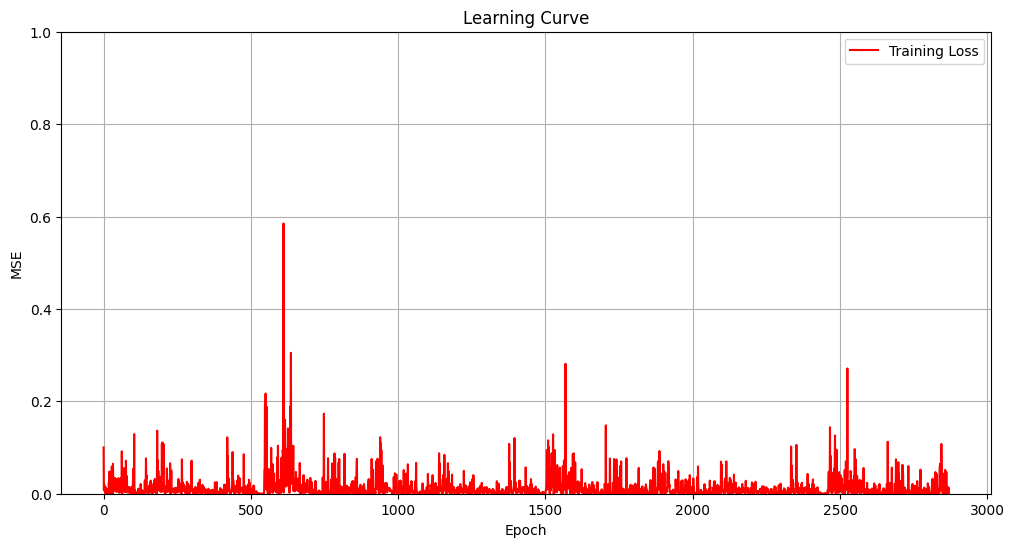

In [43]:
plt.figure(figsize=(12,6))
plt.plot(range(len(loss_list)),loss_list,"r",label="Training Loss")
plt.axis([None, None, 0, 1])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.title("Learning Curve")
plt.show()

In [44]:
test_predictions = model(test_features).detach().numpy().flatten()

dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
# test_predictions

In [45]:
dummies = np.zeros((test_features.shape[0], goback+1))
dummies[:, 0] = test_labels.flatten()
dummies = scaler.inverse_transform(dummies)

new_test_labels = dc(dummies[:, 0])
# new_test_labels

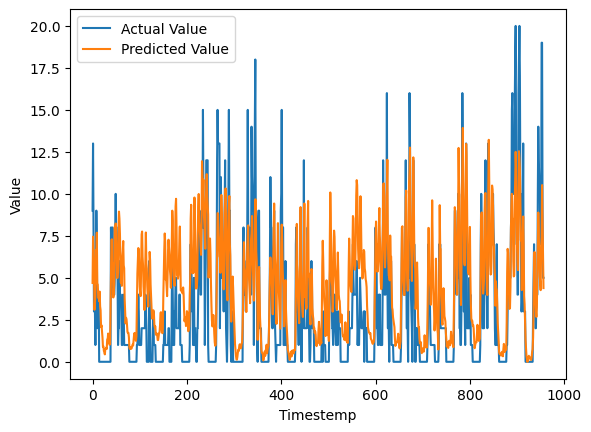

In [46]:
plt.plot(new_test_labels, label='Actual Value')
plt.plot(test_predictions, label='Predicted Value')
plt.xlabel('Timestemp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Ideas:

It is important to mention here that data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from the training set into the test set.

- make realy just predictions for the next day according to the last two weeks